In [1]:
import pandas as pd
%matplotlib inline
train = pd.read_csv("data/toxic/train.csv")
test = pd.read_csv("data/toxic/test.csv")
sample_submission = pd.read_csv("data/toxic/sample_submission.csv")

In [2]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
def add_features(train):
    train['total_length'] = train['comment_text'].apply(len)
    train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
    train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
    train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
    train['num_punctuation'] = train['comment_text'].apply(
        lambda comment: sum(comment.count(w) for w in '.,;:'))
    train['num_symbols'] = train['comment_text'].apply(
        lambda comment: sum(comment.count(w) for w in '*&$%'))
    train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
    train['num_unique_words'] = train['comment_text'].apply(
        lambda comment: len(set(w for w in comment.split())))
    train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
    train['num_smilies'] = train['comment_text'].apply(
        lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    return train

In [4]:
train = add_features(train)
test = add_features(test)

In [5]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
train.as_matrix(['num_exclamation_marks', 'num_unique_words', 'num_punctuation']).shape

(159571, 3)

计算构造出来的特征和预测label 的相关系数

In [7]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks',
            'num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words',
            'words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')

rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
df_correlations = pd.DataFrame(rows, index=features)

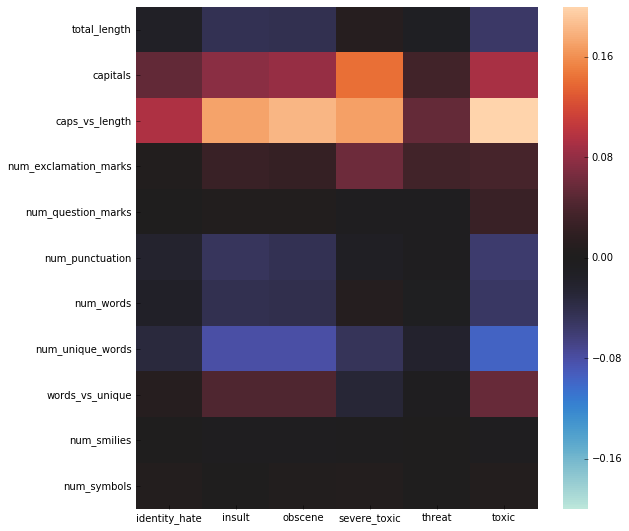

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(9, 9)) # 设置画面大小

ax = sns.heatmap(df_correlations, vmin=-0.2, vmax=0.2, center=0.0)

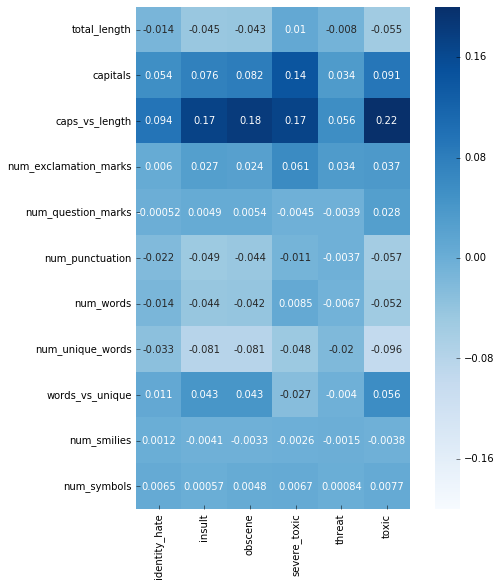

In [67]:

plt.subplots(figsize=(9, 9)) # 设置画面大小
sns.heatmap(df_correlations, annot=True, vmax=0.2, vmin=-0.2, square=True, cmap="Blues")

Proportion of capitals
Number of unique words
Number of exclamation marks
Number of punctuations

In [53]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
def clean_text(comment_text):
    comment_list = []
    for text in comment_text:
        # 将单词转换为小写
        text = text.lower()
        # 删除非字母、数字字符
        text = re.sub(r"[^A-Za-z0-9(),!?@&$\'\`\"\_\n]", " ", text)
        text = re.sub(r"\n", " ", text)
        
        # 恢复常见的简写
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"cannot", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        
        # 恢复特殊符号的英文单词
        text = text.replace('&', ' and')
        text = text.replace('@', ' at')
        text = text.replace('$', ' dollar')
        
        comment_list.append(text)
    return comment_list

train["clean_comment_text"] = clean_text(train['comment_text'])
test['clean_comment_text'] = clean_text(test['comment_text'])

all_comment_list = list(train['clean_comment_text']) + list(test['clean_comment_text'])
text_vector = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode',token_pattern=r'\w{1,}',
                         max_features=5000, ngram_range=(1, 1), analyzer='word')
text_vector.fit(all_comment_list)
train_vec = text_vector.transform(train['clean_comment_text'])
test_vec = text_vector.transform(test['clean_comment_text'])


In [54]:
train_vec.shape

(159571, 5000)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# train_vec = np.concatenate([train_vec, train.as_matrix(['num_exclamation_marks', 'num_unique_words', 'num_punctuation'])], axis=1)
# test_vec = np.concatenate([test_vec, test.as_matrix(['num_exclamation_marks', 'num_unique_words', 'num_punctuation'])],axis=1)
print(test_vec.shape)
print(train_vec.shape)
test_matrix = test.as_matrix(['num_exclamation_marks', 'num_unique_words', 'num_punctuation'])
train_matrix = train.as_matrix(['num_exclamation_marks', 'num_unique_words', 'num_punctuation'])
print(test_matrix.shape)
print(train_matrix.shape)

(153164, 5000)
(159571, 5000)
(153164, 3)
(159571, 3)


In [56]:
from scipy import sparse

In [57]:
test_vector = sparse.hstack((test_vec, test_matrix))
test_vector.shape

(153164, 5003)

In [58]:
train_vector = sparse.hstack((train_vec, train_matrix))
train_vector.shape

(159571, 5003)

In [59]:

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
x_train, x_valid, y_train, y_valid = train_test_split(train_vector, train[labels], test_size=0.1, random_state=2018)
x_test = test_vector

In [60]:
accuracy = []
for label in labels:
    clf = LogisticRegression(C=6)
    clf.fit(x_train, y_train[label])
    y_pre = clf.predict(x_valid)
    train_scores = clf.score(x_train, y_train[label])
    valid_scores = accuracy_score(y_pre, y_valid[label])
    print("{} train score is {}, valid score is {}".format(label, train_scores, valid_scores))
    accuracy.append(valid_scores)
    pred_proba = clf.predict_proba(x_test)[:, 1]
    sample_submission[label] = pred_proba
print("Total cv accuracy is {}".format(np.mean(accuracy)))

toxic train score is 0.966890184036, valid score is 0.960208046121
severe_toxic train score is 0.992061999958, valid score is 0.990287003384
obscene train score is 0.983622652545, valid score is 0.982140619125
threat train score is 0.998071205253, valid score is 0.997744078205
insult train score is 0.957469031355, valid score is 0.959832059155
identity_hate train score is 0.993844568389, valid score is 0.991477628776
Total cv accuracy is 0.980281572461


In [61]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999756,0.349211,0.999166,0.106559,0.284863,0.093082
1,0000247867823ef7,0.001912,0.000532,0.000331,0.000057,0.028633,0.000842
2,00013b17ad220c46,0.006447,0.000325,0.006208,0.000074,0.040595,0.000678
3,00017563c3f7919a,0.002030,0.002330,0.001358,0.000509,0.036368,0.000290
4,00017695ad8997eb,0.017723,0.002734,0.003999,0.001597,0.033769,0.000750


In [62]:
sample_submission.to_csv("submission.csv", index = False)